In [1]:
import datasets
from sentence_transformers import SentenceTransformer, CrossEncoder
from functools import partial
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
    
from questeval.questeval_metric import QuestEval
from questeval.utils import LinearizeWebnlgInput
import spacy

/home/teven/virtualenvs/dev_transformers/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
data_2017 = datasets.load_dataset("json", data_files="2017_scores.json")["train"]

Using custom data configuration default-ebfcb65eb55dd378
Reusing dataset json (/home/teven/.cache/huggingface/datasets/json/default-ebfcb65eb55dd378/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
data_2017

Dataset({
    features: ['all_bs160_allneg', 'all_bs192_hardneg', 'bleu', 'category', 'cross_all_bs160_allneg', 'finetuned_bi_all-mpnet-base-v2', 'finetuned_bi_all_bs160_allneg', 'finetuned_bi_all_bs192_hardneg', 'finetuned_bi_all_bs320_vanilla', 'finetuned_cross_all-mpnet-base-v2', 'finetuned_cross_all_bs160_allneg', 'finetuned_cross_all_bs192_hardneg', 'finetuned_cross_all_bs320_vanilla', 'fluency', 'grammar', 'id', 'meteor', 'mr', 'mr_processed', 'questeval_data2text', 'questeval_vanilla', 'semantics', 'systemtype', 'team', 'ter', 'text', 'triplesize', 'type'],
    num_rows: 2230
})

In [4]:
data_2017[-2]

{'all_bs160_allneg': 0.0,
 'all_bs192_hardneg': 0.0,
 'bleu': 0.0,
 'category': 'Astronaut',
 'cross_all_bs160_allneg': 0.0,
 'finetuned_bi_all-mpnet-base-v2': 0.0,
 'finetuned_bi_all_bs160_allneg': 0.0,
 'finetuned_bi_all_bs192_hardneg': 0.0,
 'finetuned_bi_all_bs320_vanilla': 0.0,
 'finetuned_cross_all-mpnet-base-v2': 0.0,
 'finetuned_cross_all_bs160_allneg': 0.0,
 'finetuned_cross_all_bs192_hardneg': 0.0,
 'finetuned_cross_all_bs320_vanilla': 0.0,
 'fluency': 1.0,
 'grammar': 1.0,
 'id': 2229,
 'meteor': 0.0,
 'mr': 'William_Anders | status | "Retired"<br>William_Anders | almaMater | "AFIT, M.S. 1962"',
 'mr_processed': '[S] William_Anders [P] status [O] "Retired" [S] William_Anders [P] almaMater [O] "AFIT, M.S. 1962" ',
 'questeval_data2text': 0.0,
 'questeval_vanilla': 0.0,
 'semantics': 1.0,
 'systemtype': 'template',
 'team': 'vietnam',
 'ter': -95.455,
 'text': None,
 'triplesize': '2triple',
 'type': 'seen'}

In [5]:
# ticks = ["semantic_adequacy", "grammaticality", "fluency", "similarity_allneg", "similarity_replaceneg", "bleu", "meteor", "ter"]
# ticks = ["semantics", "grammar", "fluency", "bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"]
ticks = ["semantics", "grammar", "fluency", "bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text"]
# ticks = ["semantics", "grammar", "fluency", "bleu", "meteor", "ter", "questeval_vanilla", "questeval_data2text",
#         'finetuned_bi_all-mpnet-base-v2',
#  'finetuned_bi_all_bs160_allneg',
#  'finetuned_bi_all_bs192_hardneg',
#  'finetuned_bi_all_bs320_vanilla',
#  'finetuned_cross_all-mpnet-base-v2',
#  'finetuned_cross_all_bs160_allneg',
#  'finetuned_cross_all_bs192_hardneg',
#  'finetuned_cross_all_bs320_vanilla',]

In [12]:
data_2017 = data_2017.filter(lambda x: x["team"] != "webnlg")
print(len(data_2017))
averaged_data = data_2017.map(lambda examples: {k: [np.mean(examples[k])] for k in ticks}, batched=True, batch_size=len(set(data_2017["team"])),
                          remove_columns=[k for k in data_2017.column_names if k not in ticks])

Loading cached processed dataset at /home/teven/.cache/huggingface/datasets/json/default-ebfcb65eb55dd378/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-c8477d7be88461df.arrow
Loading cached processed dataset at /home/teven/.cache/huggingface/datasets/json/default-ebfcb65eb55dd378/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253/cache-0d4f7bd3129016a5.arrow


2007


In [13]:
correlations = np.corrcoef(np.stack([data_2017[tick] for tick in ticks]))

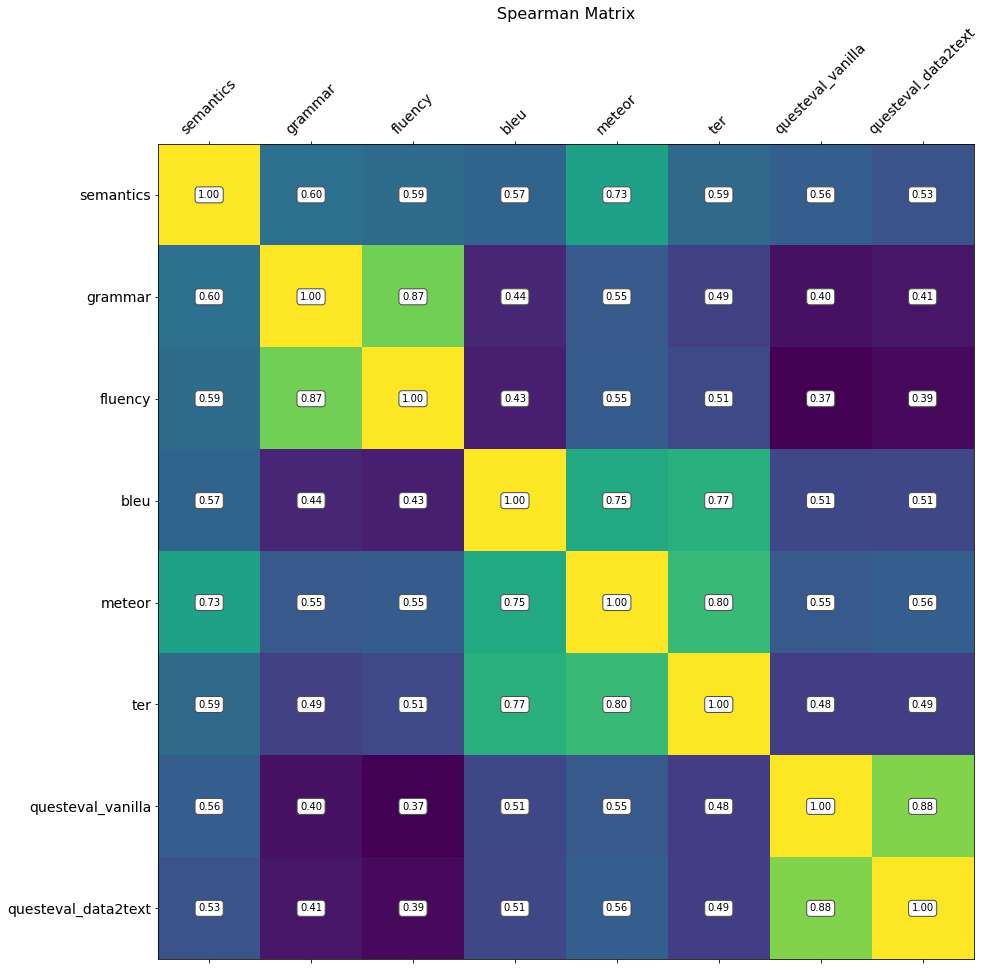

In [14]:
spearmans = spearmanr(np.stack([data_2017[tick] for tick in ticks]), axis=1)[0]
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(spearmans)
for (i, j), z in np.ndenumerate(spearmans):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45)
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

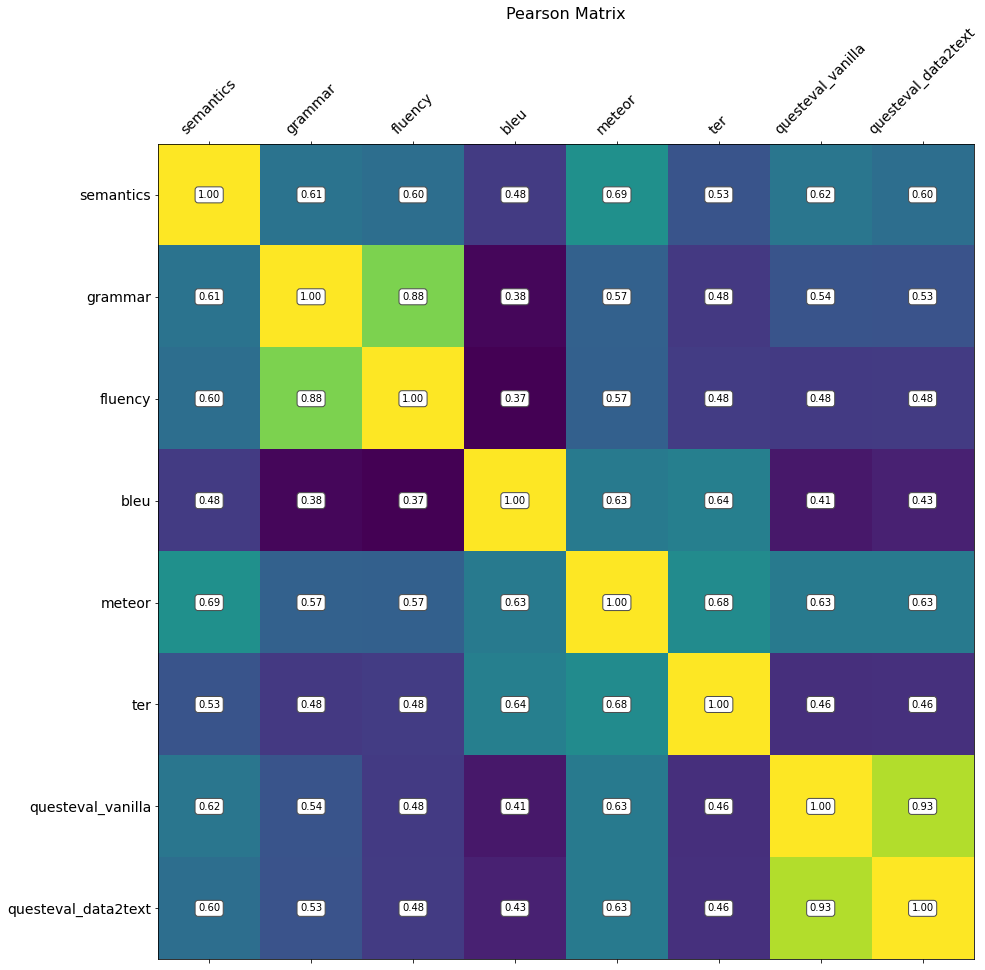

In [15]:
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations)
for (i, j), z in np.ndenumerate(correlations):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45)
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Pearson Matrix', fontsize=16);

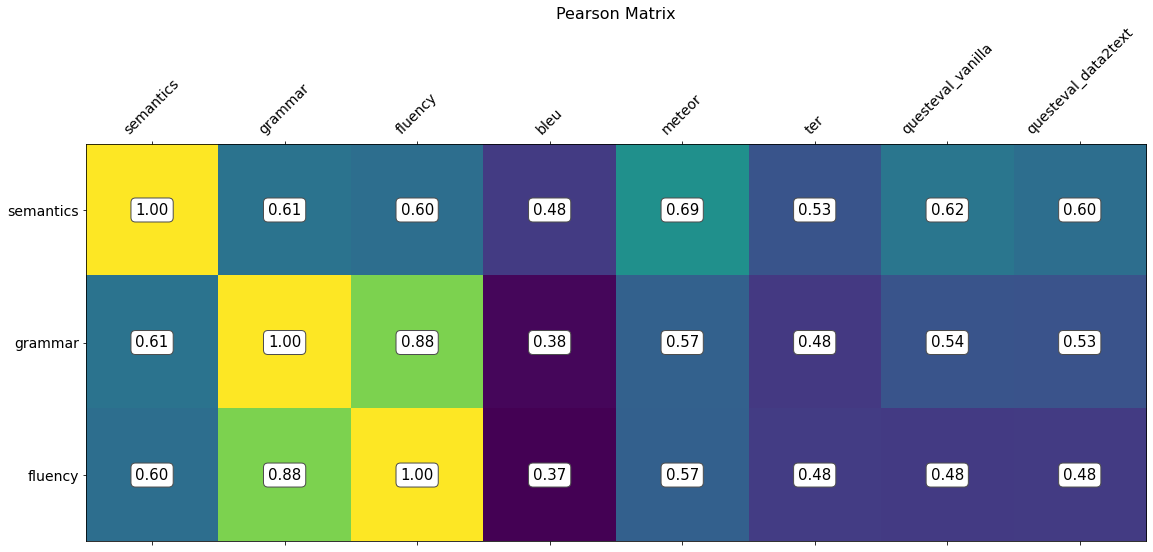

In [21]:
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations[:3, :])
for (i, j), z in np.ndenumerate(correlations):
    if i > 2:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=15,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45)
plt.yticks(range(3), ticks[:3], fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Pearson Matrix', fontsize=16);